# Implementing Attention Mechanisms

This chapter covers attention mechanisms, the engine of LLMs:

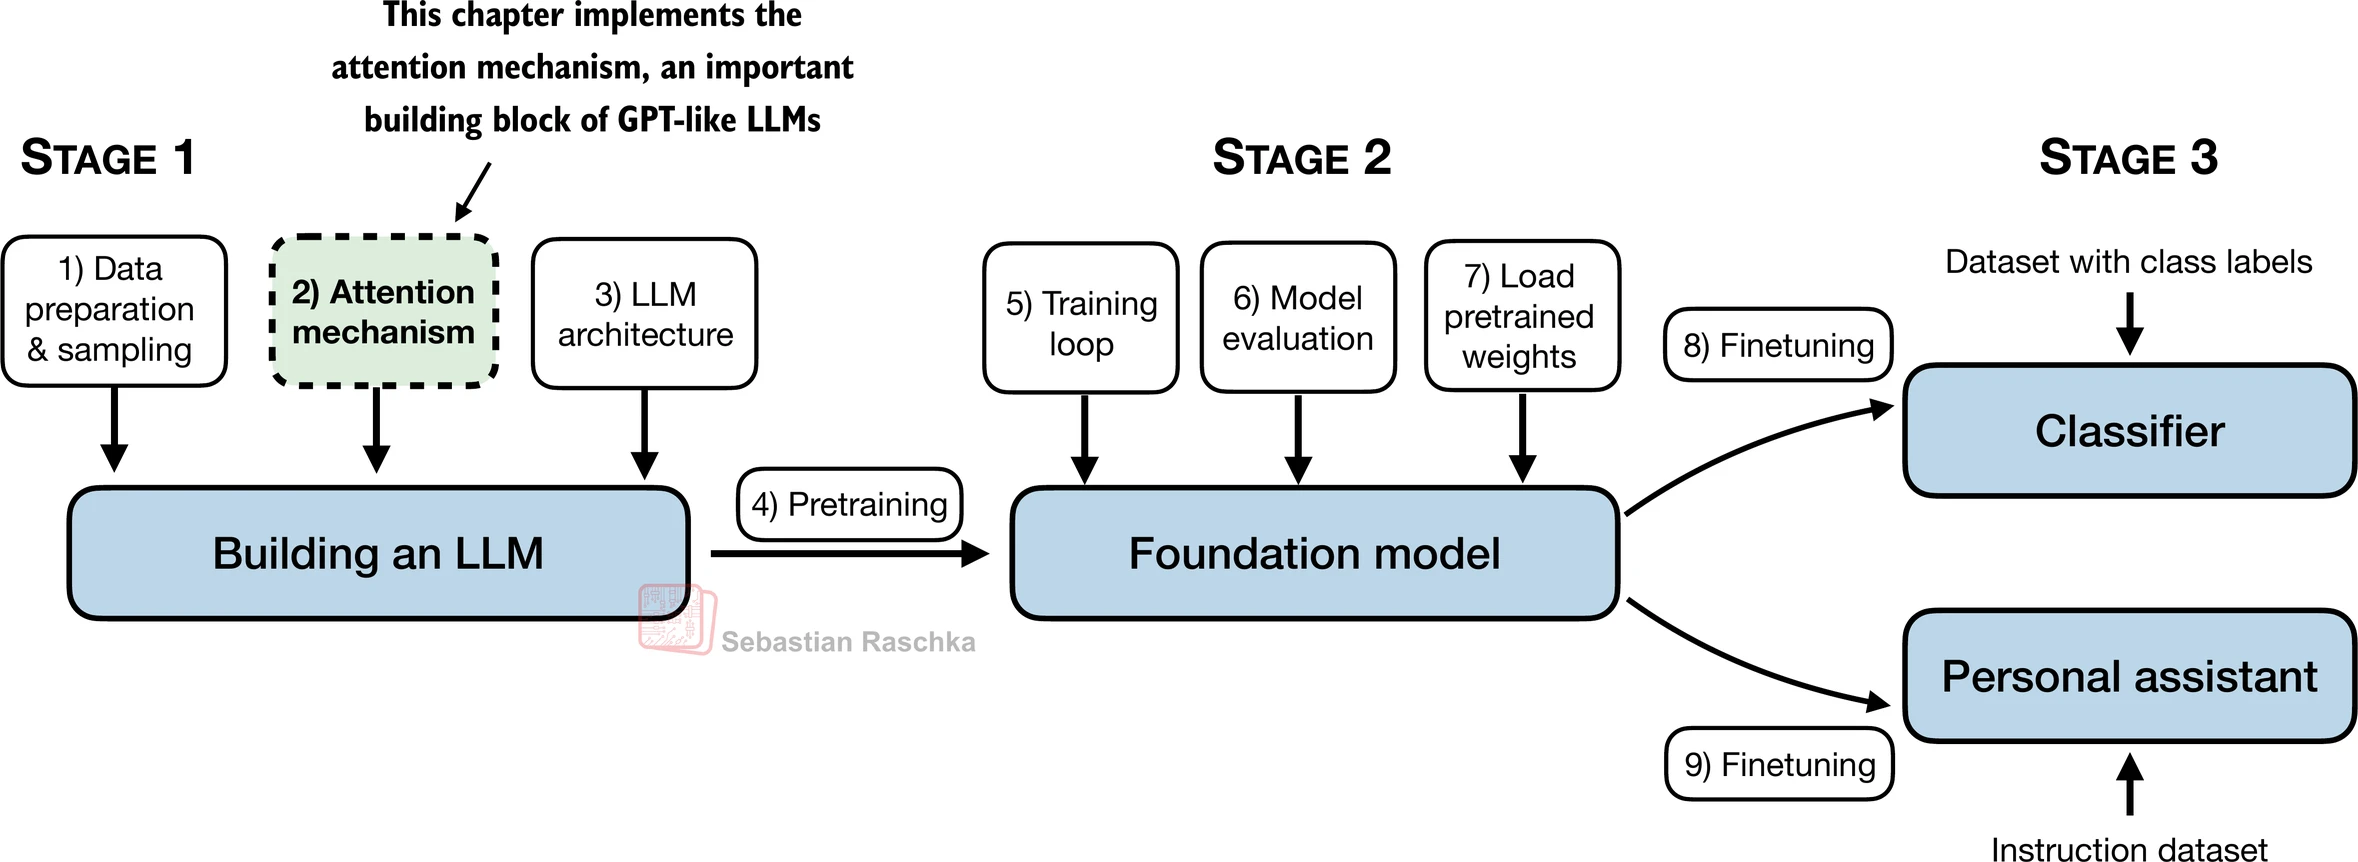

## The problem with modeling long sequences

No code in this section

Translating a text word by word isn't feasible due to the differences in grammatical structures between the source and target languages:

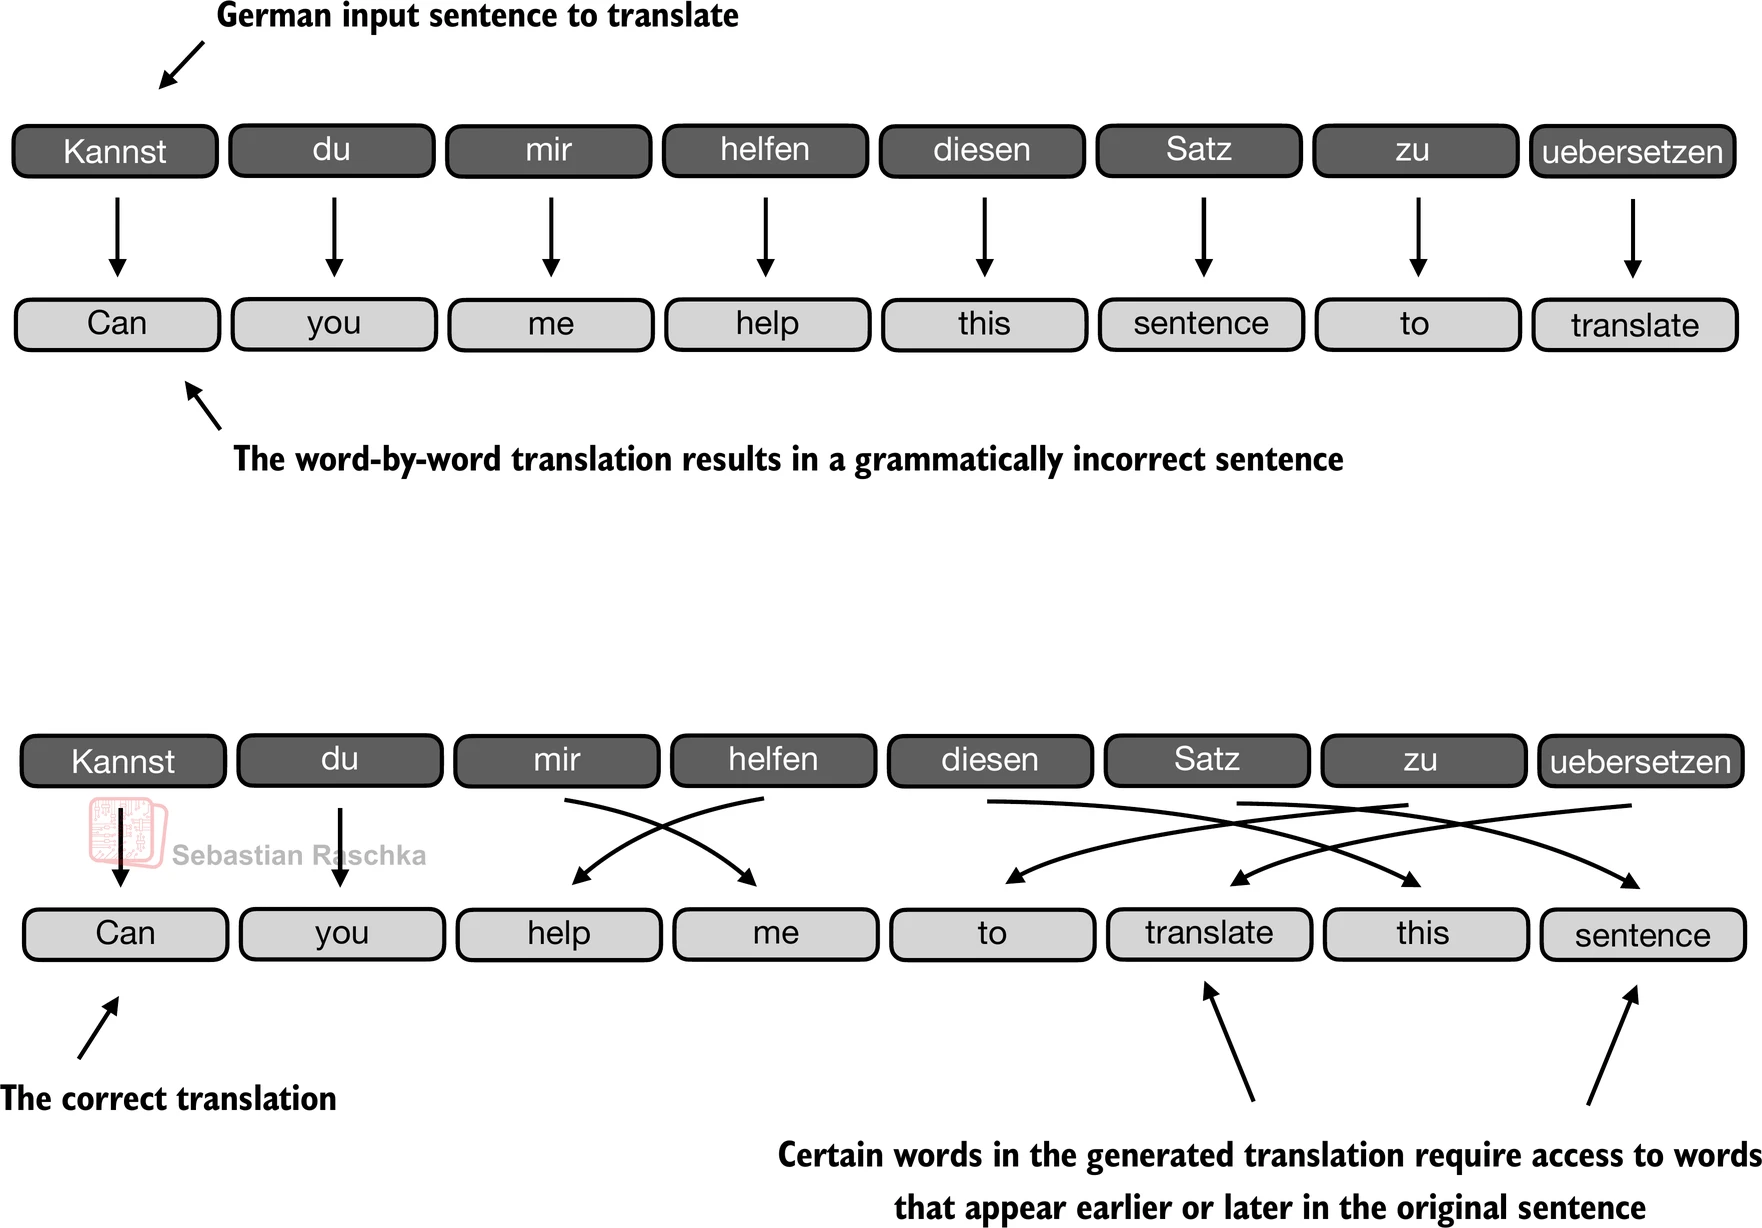

Prior to the introduction of transformer models, encoder-decoder RNNs were commonly used for machine translation tasks

In this setup, the encoder processes a sequence of tokens from the source language, using a hidden state—a kind of intermediate layer within the neural network—to generate a condensed representation of the entire input sequence:

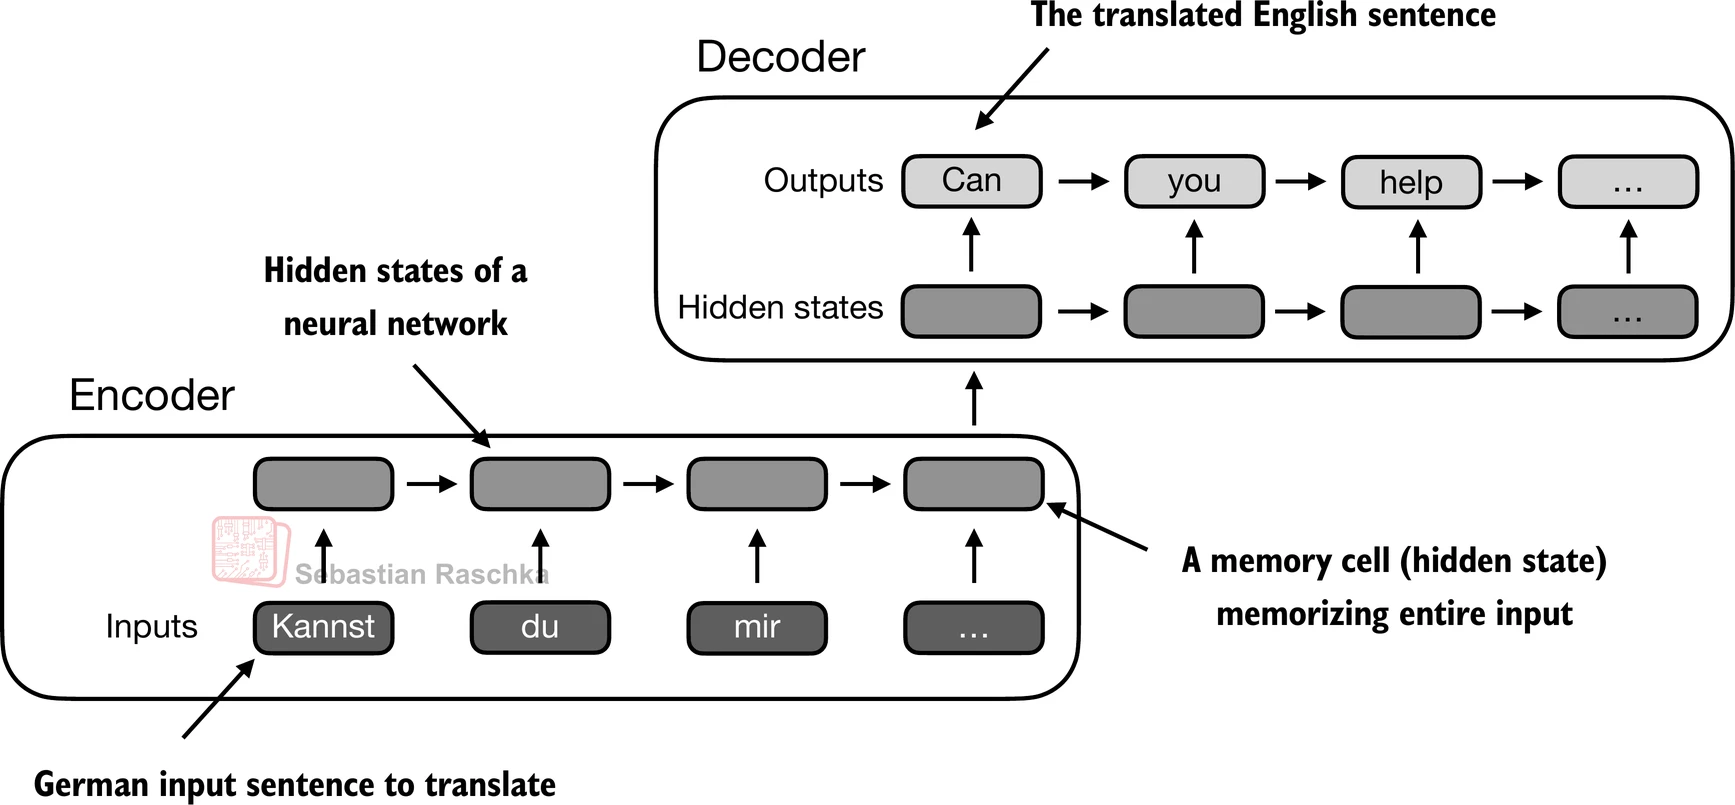

## Capturing data dependencies with attention mechanisms


Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all input tokens, implying that certain input tokens hold more significance than others in the generation of a specific output token:

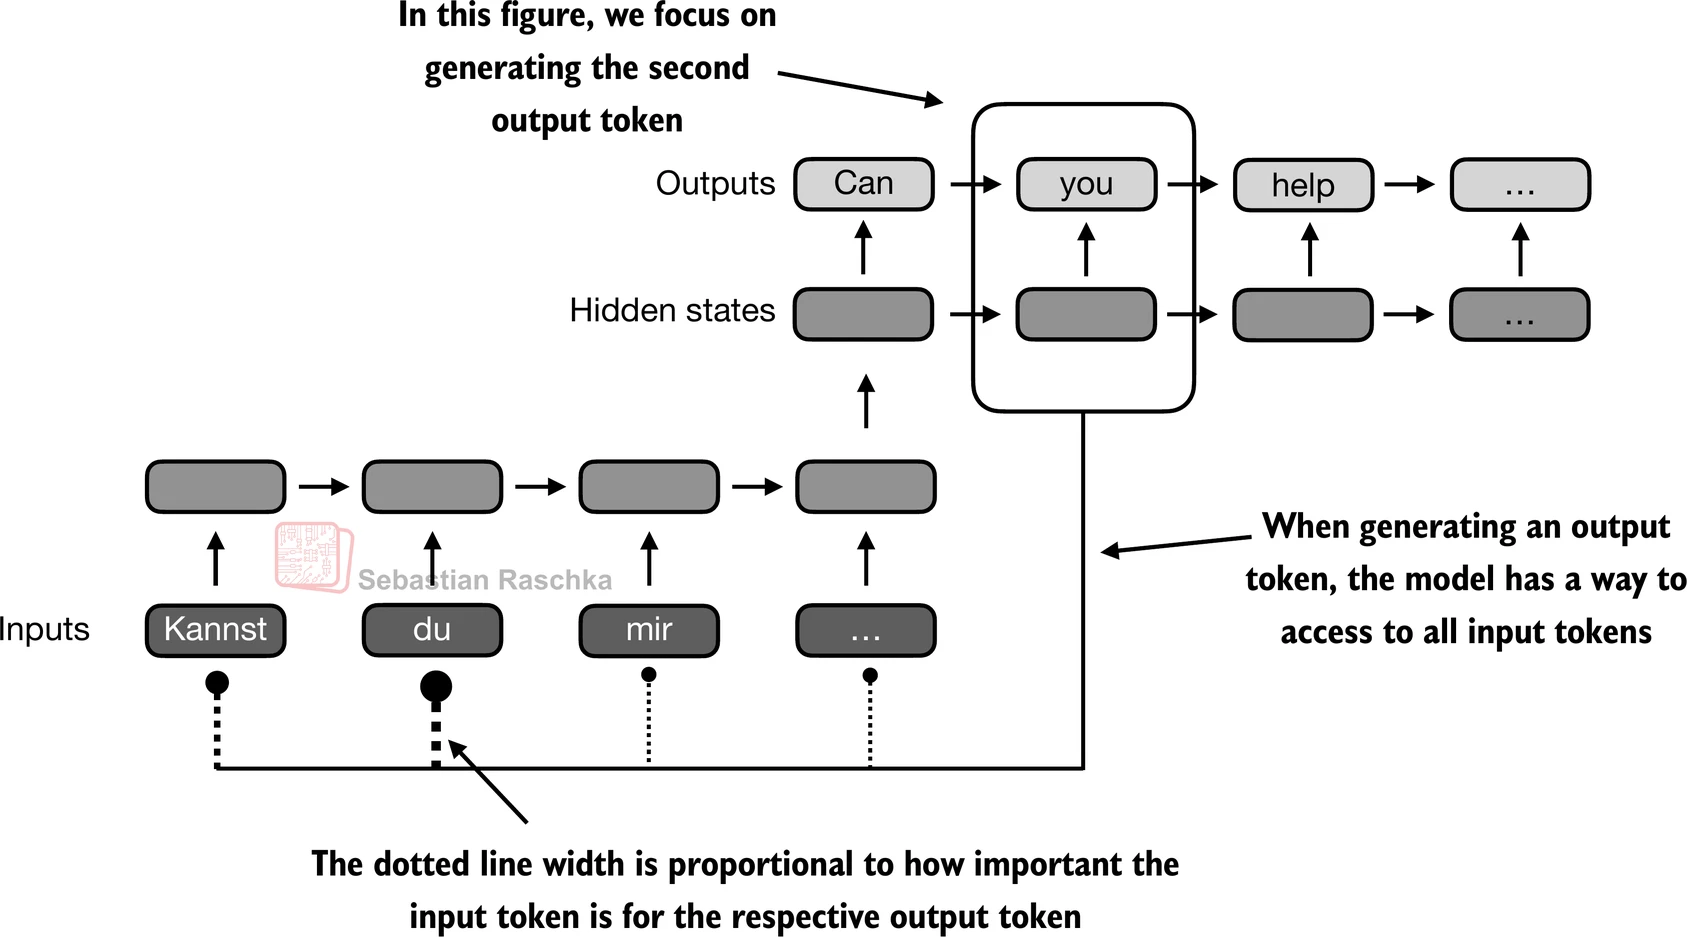

Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence

## Attending to different parts of the input with self-attention

### A simple self-attention mechanism without trainable weights

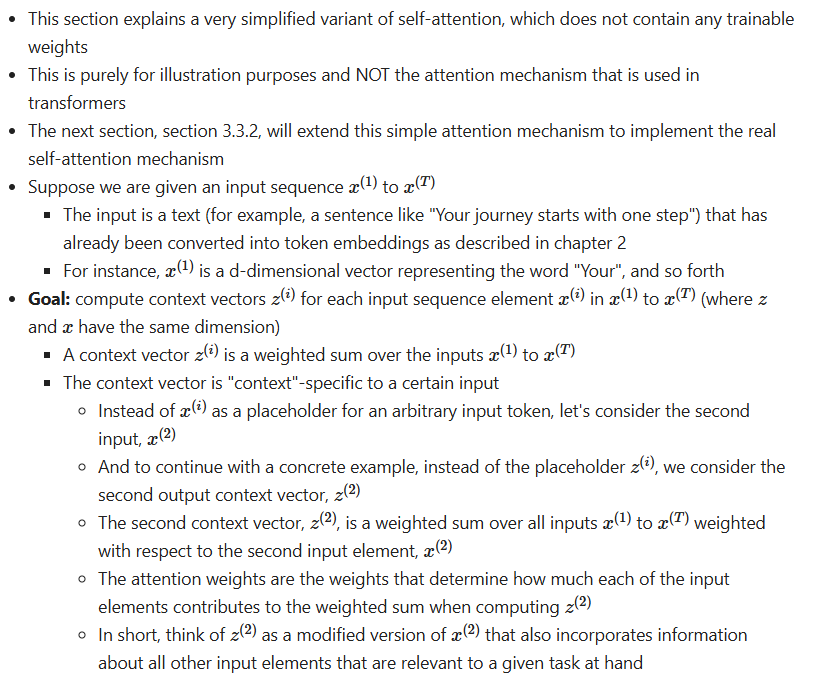

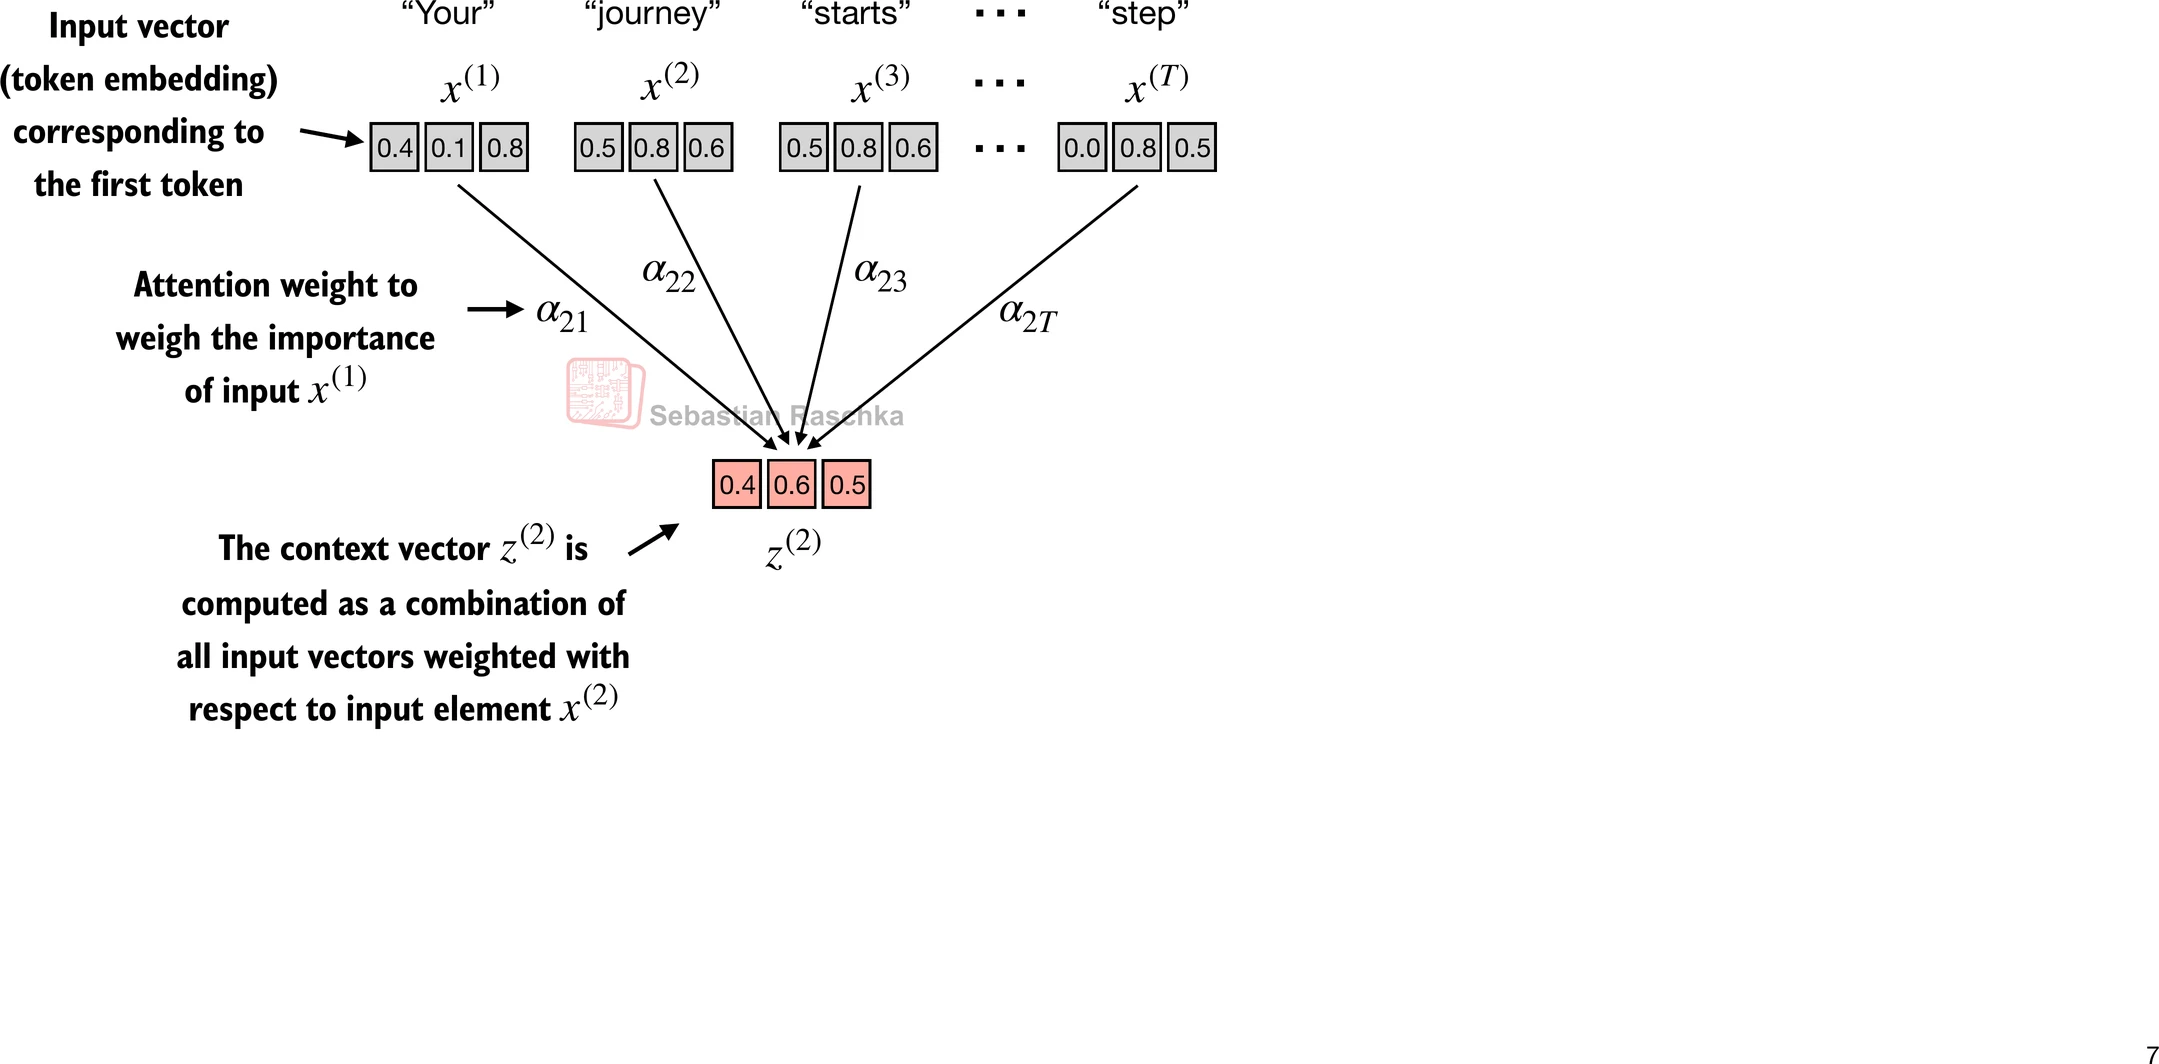

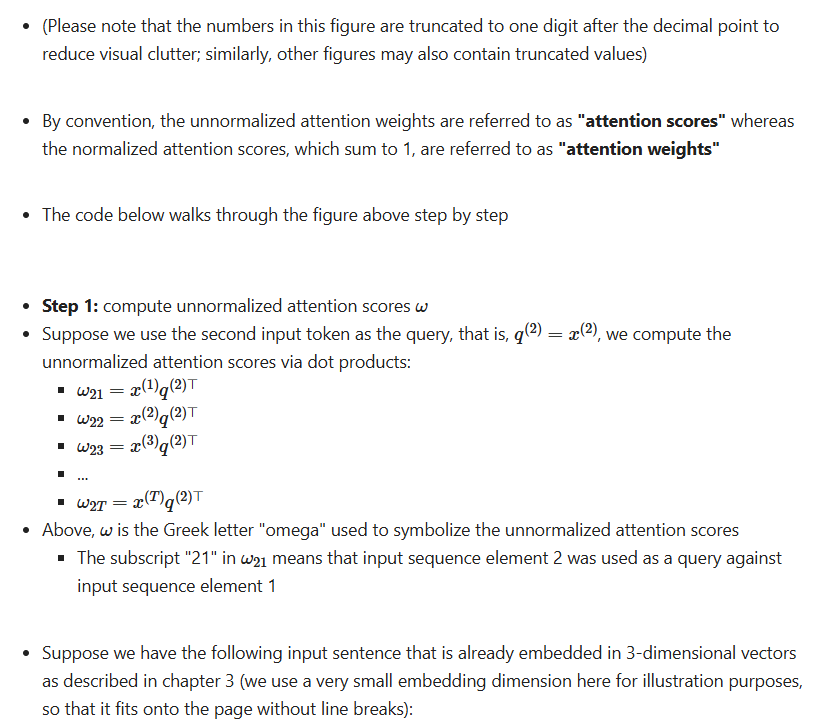

In [32]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

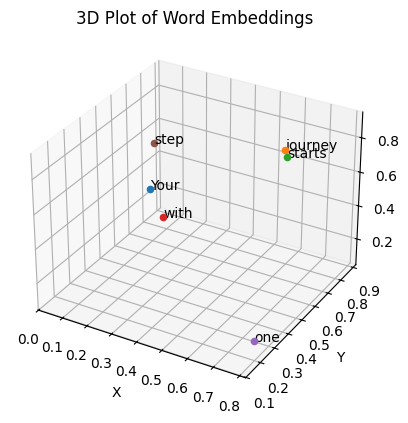

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

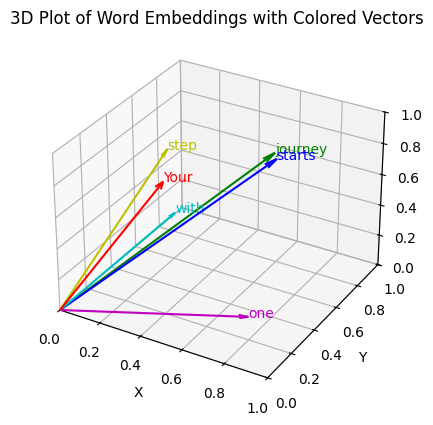

In [34]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


(In this book, we follow the common machine learning and deep learning convention where training examples are represented as rows and feature values as columns; in the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension)

The primary objective of this section is to demonstrate how the context vector 
 is calculated using the second input sequence, 
, as a query

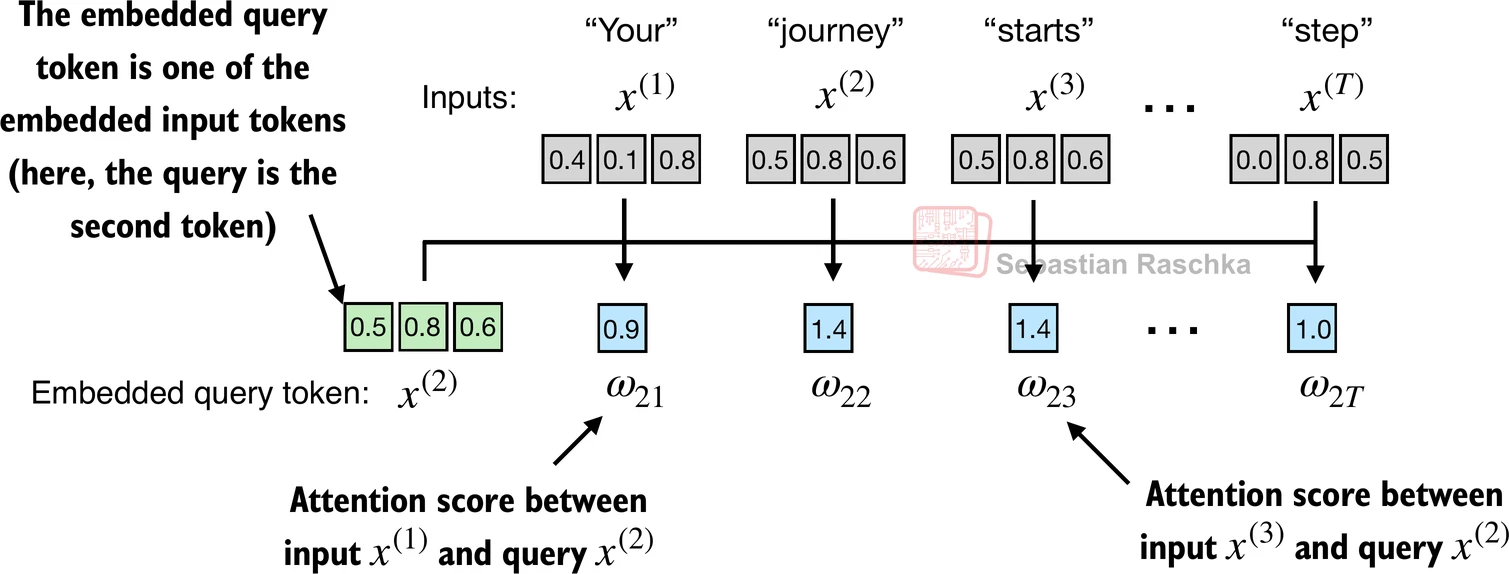


The figure depicts the initial step in this process, which involves calculating the attention scores ω between 
 and all other input elements through a dot product operation


We use input sequence element 2, 
, as an example to compute context vector 
; later in this section, we will generalize this to compute all context vectors.
The first step is to compute the unnormalized attention scores by computing the dot product between the query 
 and all other input tokens:

Each row represents a word, and each column represents an embedding dimension

The second input token serves as the query

In [35]:
query = inputs[1]   # 2nd input token is the query

attention_score_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attention_score_2[i] = torch.dot(x_i, query)  # Dot product(transpose not necessary here since they are 1-dim vectors)

print(attention_score_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In the next step, we normalize each of the attention scores that we computed previously.

The main goal behind the normalization is to obtain attention weights that sum up to 1.

This normalization is a convention that is useful for interpretation and for maintaining training stability in an LLM.

Here's a straightforward method for achieving this normalization step:

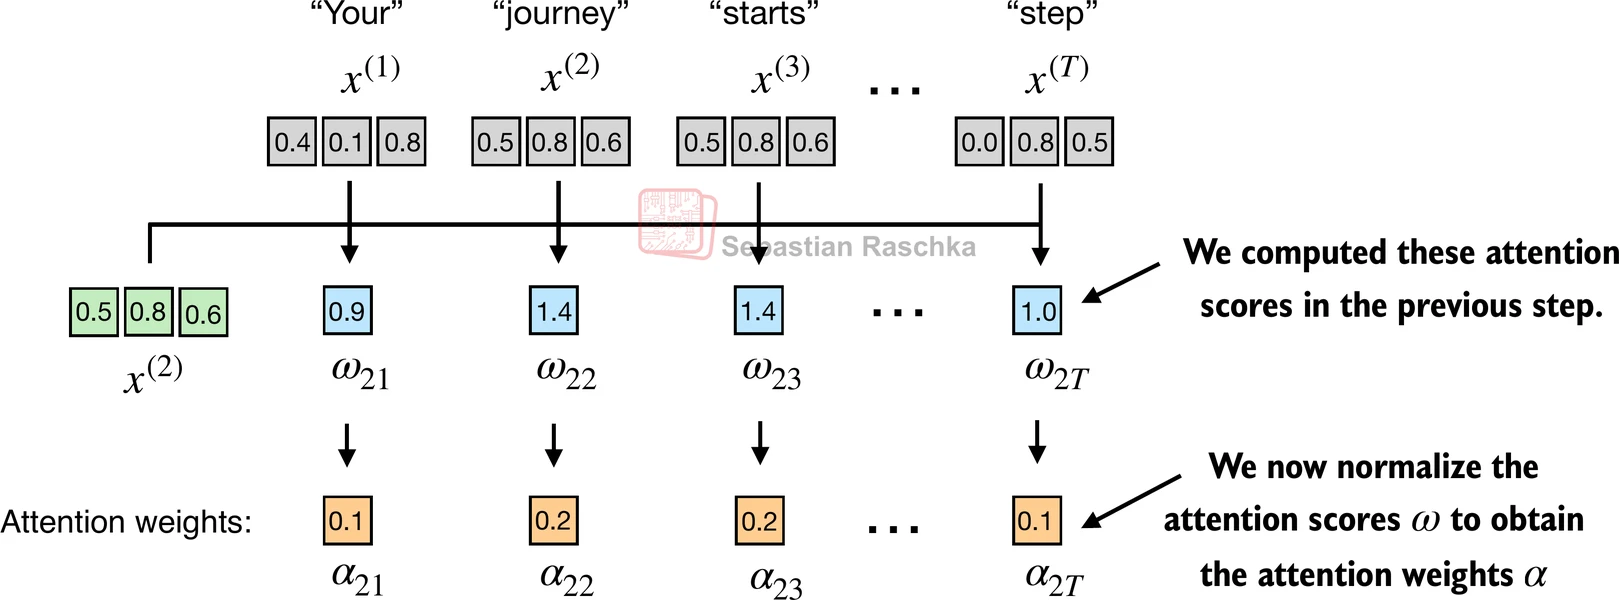

In [36]:
attention_weight_2_tmp = attention_score_2 / attention_score_2.sum()

print("Attention Weight:", attention_weight_2_tmp)
print("Sum: ", attention_weight_2_tmp.sum())

Attention Weight: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


For Journey Query the top attension score is for your, Step,

In practice, it's more common and advisable to use the softmax function for normalization.

This approach is better at managing extreme values and offers more favorable gradient properties during training.

Below is a basic implementation of the softmax function for normalizing the attention scores:

In [37]:
def softmax_naive(x):
    return torch.exp(x)  / torch.exp(x).sum(dim = 0)

attention_weight_2_native = softmax_naive(attention_score_2)

print("Attention Weight: ", attention_weight_2_native)
print("Sum: ", attention_weight_2_native.sum())

Attention Weight:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


<div class="alert alert-block alert-info">
    
As the output shows, the softmax function also meets the objective and normalizes the
attention weights such that they sum to 1:
</div>

<div class="alert alert-block alert-warning">

In addition, the softmax function ensures that the attention weights are always positive.
This makes the output interpretable as probabilities or relative importance, where higher
weights indicate greater importance.
    
</div>

<div class="alert alert-block alert-warning">

Note that this naive softmax implementation (softmax_naive) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values. 

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance:
    
</div>

In [38]:
attention_weight_2 = torch.softmax(attention_score_2, dim = 0)
print("Attention Weight: ", attention_weight_2)
print("Sum: ", attention_weight_2.sum())

Attention Weight:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


<div class="alert alert-block alert-info">
    
In this case, we can see that it yields the same results as our previous softmax_naive
function:
</div>

<div class="alert alert-block alert-success">

The context vector z(2)is calculated as a weighted sum of all input
vectors. 

This involves multiplying each input vector by its corresponding attention weight:

</div>

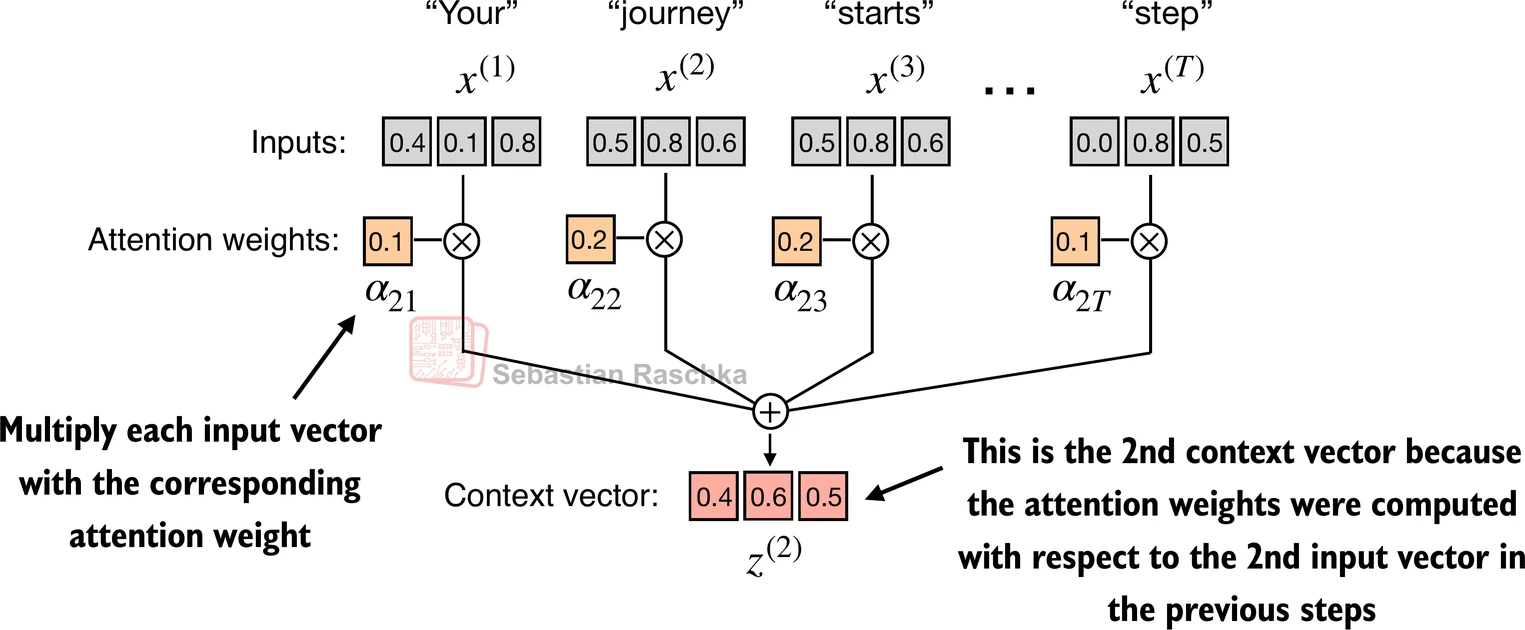

Finding the context vector

In [39]:
query = inputs[1]  # 2nd input token is the query

context_vector_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
    context_vector_2 += attention_weight_2[i]*x_i

print(context_vector_2)


tensor([0.4419, 0.6515, 0.5683])


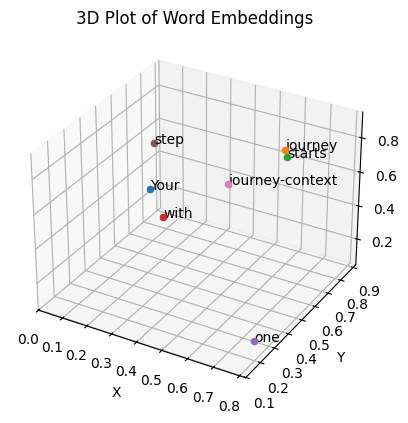

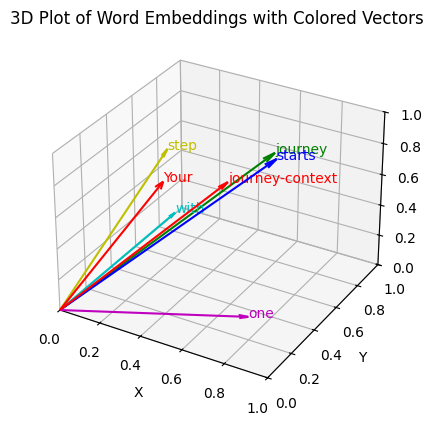

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

### Computing attention weights for all input tokens

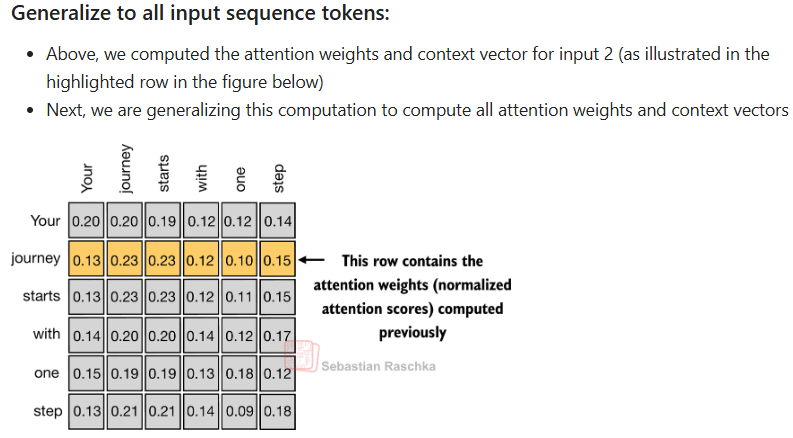

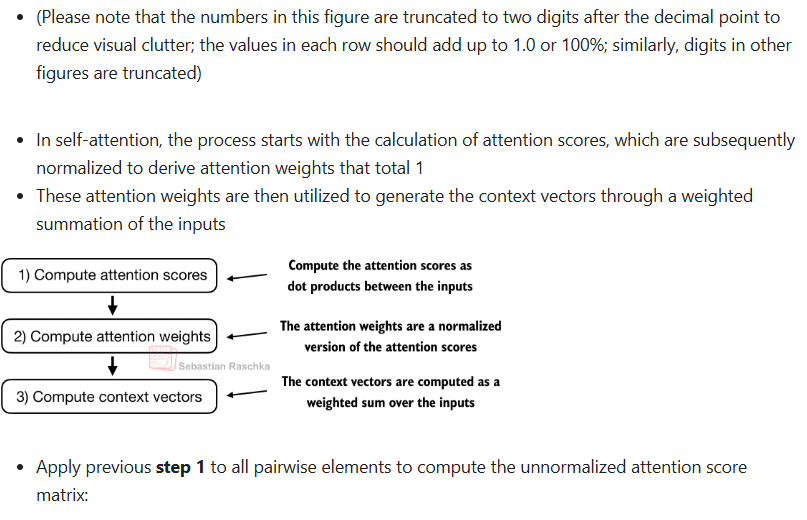

<div class="alert alert-block alert-success">

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

</div>

<div class="alert alert-block alert-success">

First, we add an additional for-loop to compute the
dot products for all pairs of inputs.

</div>

In [46]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [47]:
attention_score = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attention_score[i, j] = torch.dot(x_i, x_j)

print("Attention Score: \n", attention_score)

Attention Score: 
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-info">
    
Each element in the preceding tensor represents an attention score between each pair of
inputs.
</div>

<div class="alert alert-block alert-info">
    
When computing the preceding attention score tensor, we used for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:
</div>

In [48]:
attention_score = inputs @ inputs.T
print(attention_score)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


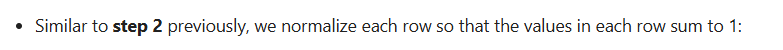

In [49]:
attention_weights = torch.softmax(attention_score, dim = 1)
print(attention_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


<div class="alert alert-block alert-warning">

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies
the dimension of the input tensor along which the function will be computed. 

By setting
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor. 

If attn_scores is a 2D tensor (for example, with a
shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in
each row (summing over the column dimension) sum up to 1.
    
</div>

<div class="alert alert-block alert-success">

Let's briefly verify that
the rows indeed all sum to 1:

</div>

In [50]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 Sum: ", row_2_sum)
print("All Row Sums: ", attention_weights.sum(dim = -1))

Row 2 Sum:  1.0
All Row Sums:  tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


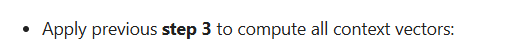

In [51]:
all_context_vectors = attention_weights @ inputs

print(all_context_vectors)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


<div class="alert alert-block alert-success">

We can double-check that the code is correct by comparing the 2nd row with the context
vector z(2) calculated previously

</div>

In [52]:
print("Previous 2nd context vector: ", context_vector_2)

Previous 2nd context vector:  tensor([0.4419, 0.6515, 0.5683])


<div class="alert alert-block alert-info">
    
Based on the result, we can see that the previously calculated context_vec_2 matches the
second row in the previous tensor exactly
</div>

<div class="alert alert-block alert-warning">

This concludes the code walkthrough of a simple self-attention mechanism.
    
</div>